<a href="https://colab.research.google.com/github/martin1tab/batch7_satellite_ges/blob/master/Find_Peaks_with_LSTM_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Loading Data


In [9]:
import sys
import pandas as pd 
import math
%matplotlib inline 
import os 
from scipy.optimize import curve_fit
import numpy as np
import torch
from torch import nn
import copy
pd.options.display.max_columns = 100

from tqdm import tqdm
import seaborn as sns
sys.path.append('/content/drive/My Drive')
from google.colab import drive
drive.mount('/content/drive')
input_dir = r'http://courty.fr/OCO2/'
df_res = pd.read_csv(input_dir + "result_for_oco2_1808.csv", sep=",")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#data_1610 = pd.read_csv("http://courty.fr/OCO2/oco2_1610.csv", sep=";")
#data_1705 = pd.read_csv("http://courty.fr/OCO2/oco2_1705.csv", sep=";")
#data_1803 = pd.read_csv("http://courty.fr/OCO2/oco2_1803.csv", sep=";")
#data_1805 = pd.read_csv("http://courty.fr/OCO2/oco2_1805.csv", sep=";")
data_1808 = pd.read_csv("/content/drive/My Drive/oco2_1808_light.csv", sep=";")
#data_1809 = pd.read_csv("http://courty.fr/OCO2/oco2_1809.csv", sep=";")

data_1808.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sounding_id,latitude,longitude,xco2,xco2_uncert,orbit,windspeed_u,windspeed_v
0,2018080100462105,-33.015541,-164.508881,405.143188,0.491368,21709,3.749916,9.128431
1,2018080100462137,-32.988529,-164.553787,404.893677,0.497189,21709,3.720200,9.087859
2,2018080100462171,-32.996235,-164.435699,404.729431,0.537358,21709,3.815527,9.151507
3,2018080100462172,-32.992409,-164.455872,404.819550,0.498803,21709,3.799832,9.138914
4,2018080100462173,-32.988403,-164.476196,404.706451,0.496855,21709,3.783962,9.126184


In [0]:
def gaussian(x, m, b, A, sig):
    return m * x + b + A / (sig * (2 * np.pi)**0.5) * np.exp(-x**2 / (2*sig**2))

def peak_detection(input_name, df_orbit, orbit_number, orbit_index, output_dir):
    window = 200 # in km
    km_start = df_orbit.loc[orbit_index, 'distance']
    # Slice back because our input point is the middle of the peak
    df_slice = df_orbit.query('distance >= (@km_start-@window/2) and distance <= (@km_start + @window/2)').copy()
    default_return = {'start_index' : df_slice.index[0],
        'end_index': df_slice.index[-1],
        'peak': False}

    # Skip if too few data
    if len(df_slice)<400:
        #print('ERROR : Not enought data')
        return default_return
    med_temp = np.median(df_slice['xco2'])
    # std_temp = np.std(df_slice['xco2']) # Not used
    df_slice['xco2_enhancement'] = df_slice['xco2'] - med_temp
    # Base parameters for : m, b, A, sig
    p0 = (0.,med_temp,30*df_slice.loc[orbit_index,'xco2_enhancement'],10.) 
    #print('Estimated parameters:', p0)
    d_centered = df_slice['distance'] - km_start
    '''
    Gaussian Fit
    scipy.optimize.curve_fit
    scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=default_return, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]¶
    p0 = Initial guess for the parameters (length N).
    sigma : Determines the uncertainty in ydata.
    '''
    popt, _ = curve_fit(f=gaussian, xdata=d_centered, ydata=df_slice['xco2'], sigma = df_slice['xco2_uncert'], p0 = p0, maxfev=20000, ftol=0.5, xtol=0.5) # ftol=0.5, xtol=0.5 to speed up
    sig = abs(popt[3])  # sigma of the Gaussian (km)
    #print(sig)
    if sig < 2 : return default_return  # too narrow
    if 3*sig > window / 2.: return default_return  # too large
    delta = popt[2]/(popt[3]*(2 * np.pi)**0.5)  # height of the peak (ppm)
    if delta < 0: return default_return  # depletion
    #d_plume = df_slice[(d_centered >= -2*sig) & (d_centered <= 2*sig)]
    #d_backg = df_slice[(d_centered < -2*sig) | (d_centered > 2*sig)]

    # we want at least 1 1-km-sounding per km on average on both sides of the peak within 2 sigmas and between 2 and 3 sigmas
    if len(df_slice[(d_centered >= -1*sig) & (d_centered <= 0)]) < int(sig): return default_return
    if len(df_slice[(d_centered <= 1*sig) & (d_centered >= 0)]) < int(sig): return default_return
    if len(df_slice[(d_centered >= -3*sig) & (d_centered <= -2*sig)]) < int(sig): return default_return
    if len(df_slice[(d_centered <= 3*sig) & (d_centered >= 2*sig)]) < int(sig): return default_return
    # check the quality of the fit
    d_peak = df_slice[(d_centered >= -4*sig) & (d_centered <= 4*sig)]
    d_peak_distance = d_peak['distance'] - df_slice.loc[orbit_index, 'distance']
    R = np.corrcoef(gaussian(d_peak_distance,*popt), d_peak['xco2'])
    if R[0,1]**2 < 0.25 : return default_return
    #print('orbit_index',orbit_index, 'Number of good fit',good_find, 'Sigma:', sig, 'Ampleur de l\'émission de CO²:',delta,'Coef de coreflation',R[0,1])
    # TODO: Add filename of input to be able to load it later
    print(df_slice.columns)
    peak = {
        'sounding_id' : df_slice.loc[orbit_index, 'sounding_id'],
        'latitude' : df_slice.loc[orbit_index, 'latitude'],
        'longitude' : df_slice.loc[orbit_index, 'longitude'],
        'orbit' : orbit_number,
        'slope' : popt[0],
        'intercept' : popt[1],
        'amplitude' : popt[2],
        'sigma': popt[3],
        'delta': delta,
        'R' : R[0,1],
        'windspeed_u' : df_slice.loc[orbit_index, 'windspeed_u'],
        'windspeed_v' : df_slice.loc[orbit_index, 'windspeed_v'],
        'peak_index': orbit_index,
        'start_index' : df_slice.index[0],
        'end_index': df_slice.index[-1],
        'peak' : True
    }
    # Save souding data around peak
    df_slice['distance'] = df_slice['distance'] - df_orbit.loc[orbit_index, 'distance']
    filename = 'peak_data' + input_name + '-o' + str(orbit_number) + '-i' + str(orbit_index) + '.json'
    df_slice.to_json(os.path.join(output_dir, filename), orient='records')
    return peak

def gaussian_fit_on_df(df_full, input_name='', output_dir=''):
    # spatial window for the detection (km)
    peak_found_number = 0
    peak_founds = []
    dfs = []
    for orbit in tqdm(df_full['orbit'].unique(), desc='Orbit'):
    #for orbit in tqdm([22061, 21928, 16134, 21715], desc='Orbit'):
        df_orbit = df_full[df_full['orbit'] == orbit].copy()
        if len(df_orbit) < 500:
            continue
        # Compute sounding distance from the begining of the orbit
        latitude_origin = df_orbit.iloc[0]['latitude']
        longitude_origin = df_orbit.iloc[0]['longitude']
        df_orbit['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin((np.radians(df_orbit['latitude'])
            - math.radians(latitude_origin))/2)**2 + math.cos(math.radians(latitude_origin))
            * np.cos(np.radians(df_orbit['latitude'])) * np.sin((np.radians(df_orbit['longitude'])
            - math.radians(longitude_origin))/2)**2))
        df_orbit = df_orbit.sort_values(by=['distance'])
        
        print(df_orbit.head)
        # Loop over the souding id's
        for i, orbit_index in tqdm(enumerate(df_orbit.index), desc='Souding', total=len(df_orbit)):
            try:
                # Work only each n soundings (15 seems good)
                #if i % 15 != 0: continue
                peak = peak_detection(input_name, df_orbit, orbit, orbit_index, output_dir)
                df_orbit.loc[orbit_index,'start_index'] = peak['start_index']
                df_orbit.loc[orbit_index,'end_index'] = peak['end_index']
                df_orbit.loc[orbit_index,'peak'] = False
                if peak['peak']:
                    peak_found_number += 1
                    peak_founds.append(peak)
                    df_orbit.loc[orbit_index,'peak'] = True

                
            except RuntimeError: 
                print('WARNING : Failed for orbit', orbit, 'and index', orbit_index)
        if peak_found_number==0:
            print('NO PEAK FOUND for orbit', orbit)
        else:
            # Save at every orbit, but with same name because we do not empty peak_founds
            filename = 'result_for_' + input_name + '.csv'
            print('Saving to', os.path.join(output_dir, filename))
            df = pd.DataFrame(peak_founds)
            df.to_csv(os.path.join(output_dir, filename))
            peak_found_number = 0

        dfs.append(df_orbit)

    return peak_founds, dfs

In [12]:
total = data_1808[0:10000]

_, dfs = gaussian_fit_on_df(total,'','/content/drive/My Drive')

newdf = \
pd.concat(dfs)


Souding:   0%|          | 19/5417 [00:00<00:28, 188.96it/s]

<bound method NDFrame.head of            sounding_id   latitude   longitude        xco2  xco2_uncert  orbit  \
0     2018080100462105 -33.015541 -164.508881  405.143188     0.491368  21709   
5     2018080100462175 -32.979904 -164.516937  405.248474     0.491248  21709   
4     2018080100462173 -32.988403 -164.476196  404.706451     0.496855  21709   
1     2018080100462137 -32.988529 -164.553787  404.893677     0.497189  21709   
6     2018080100462176 -32.975418 -164.537354  404.594025     0.499444  21709   
...                ...        ...         ...         ...          ...    ...   
5403  2018080101175473  70.003471  155.333786  402.607361     0.729847  21709   
5414  2018080101175577  70.023148  155.400375  403.088531     0.627136  21709   
5407  2018080101175504  70.012314  155.343430  402.681793     0.513250  21709   
5416  2018080101175637  70.054153  155.342606  403.895599     0.584439  21709   
5415  2018080101175636  70.061104  155.304291  404.193481     0.641344  21709  


Souding:  22%|██▏       | 1217/5417 [00:05<00:20, 209.96it/s]/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)

Souding:  55%|█████▌    | 2995/5417 [00:31<00:42, 56.42it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3026/5417 [00:31<00:50, 47.30it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3036/5417 [00:31<00:56, 41.94it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', '


Souding:  56%|█████▌    | 3046/5417 [00:32<00:57, 41.35it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  68%|██████▊   | 3673/5417 [00:39<00:36, 47.39it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  78%|███████▊  | 4229/5417 [00:50<00:24, 49.41it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  79%|███████▉  | 4295/5417 [00:51<00:21, 52.34it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  86%|████████▋ | 4675/5417 [00:59<00:13, 53.28it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  87%|████████▋ | 4707/5417 [00:59<00:15, 46.49it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  90%|████████▉ | 4872/5417 [01:02<00:10, 50.77it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  90%|█████████ | 4884/5417 [01:03<00:11, 46.81it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  91%|█████████ | 4904/5417 [01:03<00:11, 46.27it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  91%|█████████ | 4926/5417 [01:04<00:09, 49.30it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  91%|█████████▏| 4955/5417 [01:04<00:09, 47.99it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  92%|█████████▏| 4976/5417 [01:05<00:09, 48.84it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:   0%|          | 21/4583 [00:00<00:21, 208.33it/s]

Saving to /content/drive/My Drive/result_for_.csv
<bound method NDFrame.head of            sounding_id   latitude   longitude        xco2  xco2_uncert  orbit  \
5417  2018080102225277 -40.560734  172.491547  405.624542     0.349140  21710   
5420  2018080102225307 -40.543144  172.487259  405.134491     0.359491  21710   
5419  2018080102225306 -40.549381  172.512390  405.589355     0.351124  21710   
5418  2018080102225278 -40.554298  172.466339  404.842529     0.400775  21710   
5422  2018080102225336 -40.531837  172.508057  405.468597     0.346476  21710   
...                ...        ...         ...         ...          ...    ...   
9995  2018080102314038 -11.927547  166.239487  404.666016     0.831109  21710   
9996  2018080102314178 -11.854175  166.224731  404.827240     0.923796  21710   
9997  2018080102314202 -11.840197  166.304642  404.609528     0.906739  21710   
9998  2018080102314206 -11.837616  166.248947  405.523590     0.945378  21710   
9999  2018080102314208 -11.83


Souding:  34%|███▍      | 1572/4583 [00:10<00:39, 75.33it/s]/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)

Orbit: 100%|██████████| 2/2 [01:57<00:00, 58.75s/it]

NO PEAK FOUND for orbit 21710


In [0]:
def createDataset(df,timeStep=30):
  normal, anomaly = [], []

  
  for index, row in df.iterrows():
      start = row['start_index']
      end = row['end_index']
      v = []

      for index in range(int(start),int(end)):

        v.append(df.loc[index,'xco2'])

      
      if row['peak'] == False : normal.append(v)
      if row['peak'] == True : anomaly.append(v)


  return normal , anomaly


normal, anomaly = createDataset(newdf)






In [0]:
class Encoder(nn.Module):

  def __init__(self, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.n_features = n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    self.seq_len = x.shape[1]
    x = x.reshape((1,self.seq_len, self.n_features))
    
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [0]:
class Decoder(nn.Module):

  def __init__(self, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x, seq_len):
    self.seq_len = seq_len
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((1, self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [0]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(n_features, embedding_dim).to(device)
    self.decoder = Decoder(embedding_dim, n_features).to(device)

  def forward(self, x):
    seq_len = x.shape[1]
    x = self.encoder(x)
    x = self.decoder(x, seq_len)

    return x

In [0]:
def train_model(model, normal, optimizer, start_epoch, n_epochs):
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  train_dataset = normal[0:7000]
  val_dataset = normal[7000:8000]
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in tqdm(range(start_epoch, n_epochs + 1)):
    
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = torch.tensor(seq_true).reshape(1,-1,1).to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = torch.tensor(seq_true).reshape(1,-1,1).to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    #if val_loss < best_loss:
     # best_loss = val_loss
     # best_model_wts = copy.deepcopy(model.state_dict())
    savePath = "/content/drive/My Drive/classifier.pt" 

    checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
    torch.save(checkpoint, savePath)
    
    print('Epoch {0}: train loss {1} val loss {2}'.format(epoch, train_loss,val_loss))



  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [0]:
savePath = "/content/drive/My Drive/classifier.pt" 

model = RecurrentAutoencoder(1,256)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# checkpoint = torch.load(savePath)
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
model, history = train_model(
  model,
  normal,
  optimizer,
  1,
  n_epochs=90
)

  1%|          | 1/90 [06:40<9:53:41, 400.25s/it]

Epoch 1: train loss 7004.260570694651 val loss 18.503747820854187


  2%|▏         | 2/90 [13:20<9:46:56, 400.19s/it]

Epoch 2: train loss 37.16103990609305 val loss 17.091758977890013


  3%|▎         | 3/90 [19:59<9:39:54, 399.94s/it]

Epoch 3: train loss 34.44519236768995 val loss 15.571071319580078


  4%|▍         | 4/90 [26:40<9:33:28, 400.10s/it]

Epoch 4: train loss 29.780408449581692 val loss 11.976943466186523


  6%|▌         | 5/90 [33:20<9:26:53, 400.16s/it]

Epoch 5: train loss 23.346630501270294 val loss 10.017788927555085


  7%|▋         | 6/90 [40:00<9:20:13, 400.17s/it]

Epoch 6: train loss 19.125202926295145 val loss 8.107467370986939


  8%|▊         | 7/90 [46:41<9:14:02, 400.51s/it]

Epoch 7: train loss 15.352996713161469 val loss 6.394717711925507


  9%|▉         | 8/90 [53:28<9:09:42, 402.22s/it]

Epoch 8: train loss 11.983557585818428 val loss 4.905320905208588


 10%|█         | 9/90 [1:00:15<9:05:05, 403.77s/it]

Epoch 9: train loss 9.453832914522716 val loss 3.643295526981354


 11%|█         | 10/90 [1:07:01<8:59:10, 404.38s/it]

Epoch 10: train loss 6.617880257436207 val loss 2.585953458786011


In [0]:
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)


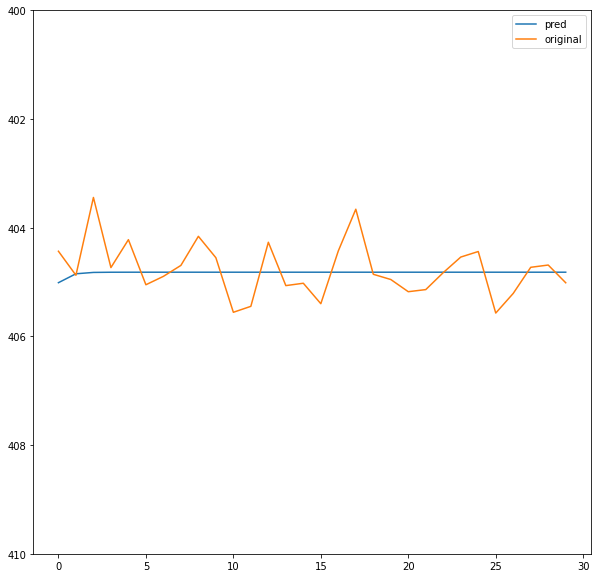

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
model(X_train[20].to(device))
plt.plot(model(X_train[10].to(device)).cpu().detach().numpy(), label = "pred")
plt.ylim(top = 400)
plt.ylim(bottom = 410)
plt.plot(X_train[20], label = "original")
plt.legend()


In [0]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.MSELoss().to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

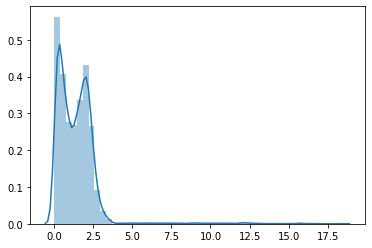

In [0]:
_, losses = predict(model, X_test)

sns.distplot(losses, bins=50, kde=True);

Correct normal predictions: 9806/9970


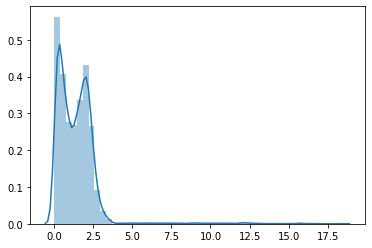

In [0]:
predictions, pred_losses = predict(model, X_test)
sns.distplot(pred_losses, bins=50, kde=True);
correct = sum(l <= 5 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(X_test)}')

In [0]:
pred_losses

[0.19266247749328613,
 0.21080151200294495,
 0.22570419311523438,
 0.23448942601680756,
 0.23707661032676697,
 0.23220817744731903,
 0.2448320984840393,
 0.24256953597068787,
 0.28763633966445923,
 0.29160013794898987,
 0.28206008672714233,
 0.2801855206489563,
 0.2768196165561676,
 0.28691402077674866,
 0.2640395164489746,
 0.25141265988349915,
 0.2685500681400299,
 0.26524555683135986,
 0.26239657402038574,
 0.26841965317726135,
 0.25373560190200806,
 0.24916799366474152,
 0.26575538516044617,
 0.18707607686519623,
 0.20638807117938995,
 0.19608457386493683,
 0.20043125748634338,
 0.2069256603717804,
 0.21472802758216858,
 0.19577351212501526,
 0.18109741806983948,
 0.1790274679660797,
 0.1888820379972458,
 0.190407395362854,
 0.20770955085754395,
 0.2061687856912613,
 0.2605680525302887,
 0.278591126203537,
 0.2330130785703659,
 0.24849417805671692,
 0.24743206799030304,
 0.25903818011283875,
 0.2845103144645691,
 0.31289300322532654,
 0.35594192147254944,
 0.3427468240261078,
 0.34

In [0]:
np.argmax(pred_losses)

5250

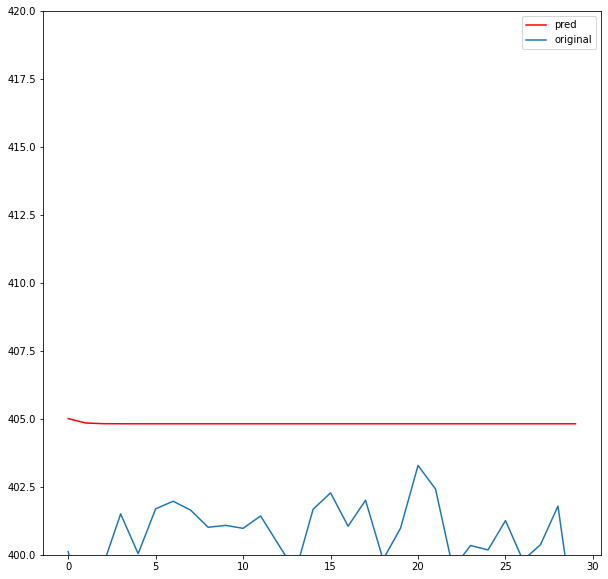

In [0]:
plt.figure(figsize=(10,10))
model(X_train[20].to(device))
plt.plot(model(X_train[5250].to(device)).cpu().detach().numpy(), color = 'red', label = "pred")
plt.ylim(top = 420)
plt.ylim(bottom = 400)
plt.plot(X_train[5250], label = "original")
plt.legend()

In [0]:
df_res

,Unnamed: 0,sounding_id,latitude,longitude,orbit,slope,intercept,amplitude,sigma,delta,R,windspeed_u,windspeed_v
0,0,2018080101035604,25.425072,-177.345490,21709,0.000430,404.902899,-14.694226,-3.987167,1.470254,0.677812,-7.759225,-0.739198
1,1,2018080101060803,32.777554,-179.428162,21709,0.002886,404.622407,1.493849,7.887665,0.075556,0.532213,-5.420354,-0.992332
2,2,2018080101062035,33.441360,-179.630508,21709,-0.002734,404.470875,18.128640,3.086571,2.343144,-0.656713,-4.649583,-0.913302
3,3,2018080101062937,33.919857,-179.779083,21709,-0.006755,404.416030,-11.847855,-3.346435,1.412432,0.592854,-4.035365,-0.879741
4,4,2018080102530302,58.858116,143.781662,21710,0.003719,399.445056,-0.018193,-5.552475,0.001307,0.730703,-3.837832,0.812698
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2734,2018083122422401,27.697588,-142.822235,22159,0.002168,403.383178,34.102413,31.243371,0.435449,0.527938,-7.121493,-0.214880
2735,2735,2018083122430537,29.928204,-143.466751,22159,-0.003651,403.579361,5.744562,5.192406,0.441365,-0.563432,-5.107835,1.853653
2736,2736,2018083122432571,31.114796,-143.827850,22159,0.006210,403.550794,0.286084,14.724687,0.007751,0.542937,-4.404825,2.101457
2737,2737,2018083122433238,31.412222,-143.909012,22159,0.003365,403.564271,15.091141,22.844005,0.263548,0.506012,-4.287163,2.074741
